### Data Load

In [1]:
dir_data = 'data/'
dir_raw = 'data/raw/'
dir_preprocessed = 'data/preprocessed/'

### EDA

##### Librerias

En este apartado, vamos a importar todas las librerías necesarias para realizar el análisis y procesamiento de datos. Estas librerías son numpy, matplotlib, pandas y seaborn. Estas librerías nos permiten manipular, visualizar y analizar los datos de manera eficiente.

In [2]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

Una vez que se han cargado, se pueden configurar algunas opciones para optimizar la visualización y el manejo de datos en pandas:

In [3]:
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.max_rows', None)     # Muestra todas las filas (¡cuidado con dataframes muy grandes!)
pd.set_option('display.width', 1000)        # Ajusta el ancho del output
pd.set_option('display.expand_frame_repr', False)  # Evita saltos de línea en columnas grandes


##### Análisis preliminar

Transformamos todos los archivos en formato CSV y añadimos una fila al final indicando la maniobra que se está representando en el conjunto de datos.

In [4]:
# Asignar otro atributo a cada dataframe de cada archivo (el nombre del archivo) y eliminación de la primera parte 'STISIMData:'.

# files = os.listdir(dir_raw)
# dfs = []
# for driver in files:
#     files = os.listdir(dir_raw + driver)
#     for file in files:
#         df = pd.read_excel(dir_raw + driver + '/' + file)
#         df['maniobra'] = file[11:-5]
#         df.to_csv(dir_preprocessed + '/column_added/' + driver + '_' + file[11:-5], index=False)
#         dfs.append(df)
#         #print(file + ' processed')
#     print(driver + ' processed')

In [5]:
dfs = []
for file in os.listdir(dir_preprocessed + '/column_added'):
    df = pd.read_csv(dir_preprocessed + '/column_added/' + file)
    dfs.append(df)

##### Valores Faltantes

Es importante verificar si hay valores faltantes en los datos, ya que pueden afectar el rendimiento del modelo. Para ello, calculamos la media de los valores faltantes por columna en cada DataFrame y mostramos los resultados.

In [6]:
# plot missing values
for df in dfs:
    print(df.isnull().mean())
    # sns.heatmap(df.isnull(), cbar=False)
    # plt.show()

Elapsed time            0.000000
Long Dist               0.000000
Lat Pos                 0.000000
Steering wheel angle    0.000000
Throttle input          0.000000
Brake pedal force       0.000000
Gas pedal               0.000000
Brake pedal             0.000000
Clutch pedal            0.000000
Left turn               0.000000
Right turn              0.000000
Gear                    0.000000
speed                   0.000000
RPM                     0.000000
Hand wheel torque       0.000000
Maneuver marker flag    0.000000
Accidents               0.999888
Collisions              0.999888
Peds Hit                0.999888
Speeding Tics           0.999888
Red Lgt Tics            0.999888
Speed Exceed            0.999888
Stop Sign Ticks         0.999888
maniobra                0.000000
dtype: float64
Elapsed time            0.000000
Long Dist               0.000000
Lat Pos                 0.000000
Steering wheel angle    0.000000
Throttle input          0.000000
Brake pedal force       0.00

Como podemos ver, hay columnas que tienen una gran cantidad de valores faltantes (>99%), por lo que procedemos a eliminarlas.

Aunque pueden ser relevantes, las consideramos no informativas ya que la cantidad es demasiado pequeña.

Nota: Pueden representar accidentes ya que el porcentaje de valores faltantes en ellas es el mismo.

Asumimos que estas filas son extras, las instancias están bien.

In [7]:
dfs = [df.drop( columns=['Accidents', 'Collisions', 'Peds Hit', 'Speeding Tics', 'Red Lgt Tics', 'Speed Exceed', 'Stop Sign Ticks']) for df in dfs]

Desechamos Long Dist, Lat Pos, Throtle input, etc. porque no son necesarias (segun el enunciado)

Utilizaremos:

* Speed - Velocidad
* RPM - Revoluciones por minuto 
* Steering Wheel angle - Ángulo del volante.  
* Gas Pedal - Pedal del acelerador. 
* Brake Pedal - Pedal del freno (b),  
* Clutch Pedal - Pedal del embrague  
* Gear – Marcha.

Nota: Tras ejecutar el modelo (clasificación multiclase con xgboost) con un extremadamente alto rendimiento, se sospechó de que hubiese fuga de datos. Para comprobarlo, se realizaron varias pruebas quitando atributos de manera selectiva hasta que se vio una caída abismal de la precisión cuando se quitaron los atributos de Latitud y Longitud. Se sospecha que esto podría ser algo del simulador de donde se obtuvieron los datos.

In [8]:
dfs = [df.drop(columns=['Elapsed time', 'Long Dist', 'Lat Pos', 'Hand wheel torque', 'Throttle input']) for df in dfs]

In [9]:
dfs[0].head()

,Steering wheel angle,Brake pedal force,Gas pedal,Brake pedal,Clutch pedal,Left turn,Right turn,Gear,speed,RPM,Maneuver marker flag,maniobra
0,-8.24,1.36,0,0,0,0,0,0,0.06,147.244,0,3step-Turnings
1,-8.24,1.36,0,0,0,0,0,0,0.04,184.118,0,3step-Turnings
2,-8.24,1.36,0,0,0,0,0,0,0.02,219.193,0,3step-Turnings
3,-8.24,1.36,0,0,0,0,0,0,0.00,252.554,0,3step-Turnings
4,-8.24,1.36,0,0,0,0,0,0,0.00,284.287,0,3step-Turnings


Una vez que los datos están cargados y preprocesados, obtenemos una visión general de las estadísticas descriptivas de las columnas. Esto nos ayuda a entender las distribuciones y el rango de los datos, así como a identificar posibles valores atípicos.

In [10]:
for df in dfs:
    # Imprimir el máximo, mínimo y promedio de cada columna
    print(df.describe().loc[['max', 'min', 'mean']])

      Steering wheel angle  Brake pedal force     Gas pedal   Brake pedal  Clutch pedal  Left turn  Right turn      Gear      speed          RPM  Maneuver marker flag
max             414.060000          87.160000  59627.000000  29041.000000  64253.000000   1.000000         0.0  4.000000  84.590000  4774.648000              1.000000
min            -466.580000           1.360000      0.000000      0.000000      0.000000   0.000000         0.0 -1.000000   0.000000   124.919000              0.000000
mean             -4.288223           4.866916  19731.515392   1187.196239  32681.562745   0.115527         0.0  0.983656  27.076534  1690.436524              0.591627
      Steering wheel angle  Brake pedal force     Gas pedal   Brake pedal  Clutch pedal  Left turn  Right turn      Gear      speed          RPM  Maneuver marker flag
max              22.660000          30.970000  53331.000000  10023.000000  64253.000000    1.00000    1.000000  4.000000  90.610000  4119.349000              1.00000

In [11]:
# Mostrar un histograma de cada columna con el título 'maniobra'
# for df in dfs:
#     df.hist(figsize=(20, 20))
#     plt.suptitle(df['maniobra'][0])
#     plt.show()

No vemos valores atípicos claros o valores incorrectos, por lo que no eliminaremos ninguna instancia.

Dado que hay instancias donde no se realizan maniobras, decidimos eliminarlas ya que no proporcionan información útil.

In [12]:
# Eliminar las filas del dataframe que tienen 0 en 'Maneuver marker flag'
dfs_cleaned = []
for df in dfs:
    # Encuentra los índices donde 'Maneuver marker flag' es 1
    marker_indices = df[df['Maneuver marker flag'] == 1].index

    if not marker_indices.empty:  # Si hay al menos un 1 en la columna
        last_index = marker_indices[-1]  # Última ocurrencia de 1
        dfs_cleaned.append(df.iloc[:last_index + 1])  # Mantener todo hasta ahí
    else:
        dfs_cleaned.append(df)  # Si no hay 1s, mantener el DataFrame intacto

dfs = dfs_cleaned

Observamos que el 3 step turning puede ser tanto 3step-Turning como 3step-Turnings, por lo que nos quedamos con la primera

In [13]:
# Cambiar el valor de la columna 'maniobra' de "3step-Turnings" a "3step-Turn"
def change_maniobra(df):
    df['maniobra'] = df['maniobra'].apply(lambda x: '3step-Turning' if x == '3step-Turnings' else x)
    return df

In [14]:
dfs = [change_maniobra(df) for df in dfs]

##### Concatenar en drivers

Combinamos los distintos DataFrames de cada conductor en un único DataFrame para facilitar su procesamiento. Esto nos permitirá entrenar el modelo con un conjunto de datos unificado y obtener mejores generalizaciones.

Antes de concatenar los DataFrames, es importante dividir los datos en conjuntos de entrenamiento y prueba para evaluar el rendimiento del modelo de manera objetiva. Usaremos una proporción de 4:1, es decir, el 80% de los datos para entrenamiento y el 20% para prueba.

In [15]:
# Separar los dataframes en entrenamiento y prueba en una proporción de 4 a 1
dfs_train = dfs[:-10]
dfs_test = dfs[-10:]

Ahora, combinamos todos los DataFrames en un solo DataFrame para cada conjunto (entrenamiento y prueba). Esto facilita el manejo de los datos, ya que tendremos un único DataFrame con todas las muestras en lugar de múltiples archivos separados.

In [16]:
# Combinar los dataframes de entrenamiento
df_train = pd.concat(dfs_train)
# Combinar los dataframes de prueba
df_test = pd.concat(dfs_test)

##### Aplanar Conjunto de Datos

Ahora procedemos a aplanar los datos. Esto significa que vamos a transformar los datos secuenciales en una representación más estructurada que pueda ser utilizada por un modelo de Machine Learning de manera eficiente.

Dado que los datos están organizados temporalmente, utilizaremos agregaciones estadísticas y medias móviles para capturar la información relevante en cada segmento de conducción.

In [17]:
def flattenMA(df):
    # Define cuáles columnas son numéricas y cuáles categóricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Quitamos 'flag' de la lista numérica (si no queremos procesarla)
    if 'Maneuver marker flag' in numeric_cols:
        numeric_cols.remove('Maneuver marker flag')

    categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

    # Define las ventanas para los moving averages
    window1 = 30
    window2 = 60
    window3 = 100
    window4 = 150 
    window5 = 200
    window6 = 200

    # Separamos el DataFrame en segmentos:
    # Cada segmento contiene las filas con flag==0 hasta antes de aparecer un 1.
    segments = []
    segment_rows = []

    for _, row in df.iterrows():
        if row['Maneuver marker flag'] == 1:
            # Cuando encontramos un 1, si tenemos filas acumuladas en el segmento, lo agregamos y reiniciamos
            if segment_rows:
                segments.append(pd.DataFrame(segment_rows))
                segment_rows = []
        else:
            segment_rows.append(row)

    # Agregar el último segmento (si no finaliza en 1)
    if segment_rows:
        segments.append(pd.DataFrame(segment_rows))

    # Procesamos cada segmento para obtener las agregaciones:
    result = []
    for seg in segments:
        seg_result = {}
        
        # Para las columnas numéricas, calculamos dos moving averages y tomamos el último valor de cada serie
        for col in numeric_cols:
            # Calculate MA according to the window
            ma1 = seg[col].rolling(window=window1, min_periods=1).mean().iloc[-1]
            ma2 = seg[col].rolling(window=window2, min_periods=1).mean().iloc[-1]
            ma3 = seg[col].rolling(window=window3, min_periods=1).mean().iloc[-1]
            ma4 = seg[col].rolling(window=window4, min_periods=1).mean().iloc[-1]
            ma5 = seg[col].rolling(window=window5, min_periods=1).mean().iloc[-1]
            # ma6 = seg[col].rolling(window=window6, min_periods=1).mean().iloc[-1]

            seg_result[f"{col}_ma1"] = ma1
            seg_result[f"{col}_ma2"] = ma2
            seg_result[f"{col}_ma3"] = ma3
            seg_result[f"{col}_ma4"] = ma4
            seg_result[f"{col}_ma5"] = ma5
            # seg_result[f"{col}_ma6"] = ma6
        
        # Para las columnas categóricas, se extrae una lista de valores únicos que aparecieron
        for col in categorical_cols:
            unique_vals = seg[col].unique().tolist()
            seg_result[col] = unique_vals
        
        result.append(seg_result)

    # Se crea el DataFrame final aplanado (cada fila es un segmento)
    df_result = pd.DataFrame(result)
    return df_result

Aplicamos la función flattenMA() a los conjuntos de entrenamiento y prueba para obtener la versión aplanada de los datos.

In [18]:
df_train_flat = flattenMA(df_train)
df_test_flat = flattenMA(df_test)

Comprobamos si la distribución de maniobras sigue siendo balanceada o si hay alguna clase que domine en exceso.

In [19]:
print(df_train_flat['maniobra'].value_counts())
print(df_test_flat['maniobra'].value_counts())

maniobra
[Stopping]         45
[Turnings]         45
[3step-Turning]    30
[U-Turnings]       29
[Overtaking]       28
Name: count, dtype: int64
maniobra
[Turnings]         40
[Stopping]         30
[3step-Turning]    20
[Overtaking]       20
[U-Turnings]       17
Name: count, dtype: int64


Hemos verificado que no hay problemas con maniobra, así que eliminamos la lista y mantenemos el elemento que contiene.

In [20]:
df_train_flat['maniobra'] = df_train_flat['maniobra'].apply(lambda x: x[0])

df_test_flat['maniobra'] = df_test_flat['maniobra'].apply(lambda x: x[0])

In [21]:
df_train_flat.head(3)

,Steering wheel angle_ma1,Steering wheel angle_ma2,Steering wheel angle_ma3,Steering wheel angle_ma4,Steering wheel angle_ma5,Brake pedal force_ma1,Brake pedal force_ma2,Brake pedal force_ma3,Brake pedal force_ma4,Brake pedal force_ma5,Gas pedal_ma1,Gas pedal_ma2,Gas pedal_ma3,Gas pedal_ma4,Gas pedal_ma5,Brake pedal_ma1,Brake pedal_ma2,Brake pedal_ma3,Brake pedal_ma4,Brake pedal_ma5,Clutch pedal_ma1,Clutch pedal_ma2,Clutch pedal_ma3,Clutch pedal_ma4,Clutch pedal_ma5,Left turn_ma1,Left turn_ma2,Left turn_ma3,Left turn_ma4,Left turn_ma5,Right turn_ma1,Right turn_ma2,Right turn_ma3,Right turn_ma4,Right turn_ma5,Gear_ma1,Gear_ma2,Gear_ma3,Gear_ma4,Gear_ma5,speed_ma1,speed_ma2,speed_ma3,speed_ma4,speed_ma5,RPM_ma1,RPM_ma2,RPM_ma3,RPM_ma4,RPM_ma5,maniobra
0,-2.060000,-2.247000,-1.4098,-0.939867,-1.5680,13.240333,29.473167,19.9112,13.727467,10.63560,0.000000,0.0,4157.55,19000.200000,24451.97,4021.966667,9516.366667,6279.71,4186.473333,3139.855,64253.000000,64253.000000,58051.05,39418.546667,33001.550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.466667,1.933333,2.36,2.573333,2.680,18.144333,35.883000,51.4298,57.698400,58.94485,960.290467,1069.358083,1577.89782,1886.409440,2202.655060,3step-Turning
1,-355.825333,-141.931333,-37.2666,-6.018800,-3.8819,1.360000,1.360000,1.3600,6.774200,7.06785,12778.666667,17894.4,15030.40,10020.266667,7822.72,0.000000,0.000000,0.00,1832.833333,1932.305,32446.433333,25949.366667,32977.87,43402.913333,47684.545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.89,0.700000,1.025,6.365333,5.888000,3.7316,6.032600,14.49150,1173.573067,1160.573883,1057.40803,1024.547700,1183.185515,3step-Turning
2,1.987333,-1.291333,-0.7768,-0.024133,-0.7593,17.694667,14.364000,11.0262,7.804133,6.19310,0.000000,0.0,89.60,16993.253333,27215.47,5529.700000,4402.150000,3272.22,2181.480000,1636.110,64253.000000,64253.000000,63604.04,47023.540000,37907.935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,1.950000,2.16,2.773333,3.080,47.726667,54.127667,62.9447,67.440133,67.52050,933.228633,991.168350,1345.80681,1636.654793,1691.548615,3step-Turning


Para asegurar que los datos procesados se puedan reutilizar sin repetir todo este proceso, guardamos los DataFrames en formato CSV.

In [22]:
# Guardar en CSV
df_train_flat.to_csv(dir_preprocessed + 'non_minmax/' + 'train_flat.csv', index=False)
df_test_flat.to_csv(dir_preprocessed + 'non_minmax/' + 'test_flat.csv', index=False)

### Entrenamiento del Modelo (Clasificador Multiclase)

En esta sección, tomamos los datos aplanados y los preparamos para entrenar un modelo de clasificación multiclase. Nuestro objetivo es entrenar un modelo que pueda predecir correctamente la maniobra realizada en función de las características extraídas.

In [23]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  # Puedes usar StandardScaler si lo prefieres
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

##### Asignar Datos

Ahora que los datos han sido transformados, los separamos en variables independientes (X) y la variable objetivo (y).

In [24]:
X_train = df_train_flat.drop(columns='maniobra')
y_train = df_train_flat['maniobra']
X_test = df_test_flat.drop(columns='maniobra')
y_test = df_test_flat['maniobra']

Antes de continuar, es útil verificar que las características se han asignado correctamente.

In [25]:
X_test.head()

,Steering wheel angle_ma1,Steering wheel angle_ma2,Steering wheel angle_ma3,Steering wheel angle_ma4,Steering wheel angle_ma5,Brake pedal force_ma1,Brake pedal force_ma2,Brake pedal force_ma3,Brake pedal force_ma4,Brake pedal force_ma5,Gas pedal_ma1,Gas pedal_ma2,Gas pedal_ma3,Gas pedal_ma4,Gas pedal_ma5,Brake pedal_ma1,Brake pedal_ma2,Brake pedal_ma3,Brake pedal_ma4,Brake pedal_ma5,Clutch pedal_ma1,Clutch pedal_ma2,Clutch pedal_ma3,Clutch pedal_ma4,Clutch pedal_ma5,Left turn_ma1,Left turn_ma2,Left turn_ma3,Left turn_ma4,Left turn_ma5,Right turn_ma1,Right turn_ma2,Right turn_ma3,Right turn_ma4,Right turn_ma5,Gear_ma1,Gear_ma2,Gear_ma3,Gear_ma4,Gear_ma5,speed_ma1,speed_ma2,speed_ma3,speed_ma4,speed_ma5,RPM_ma1,RPM_ma2,RPM_ma3,RPM_ma4,RPM_ma5
0,0.918000,-1.086000,-0.9002,-0.894400,-0.946500,3.610333,2.485167,2.0351,1.810067,1.697550,1704.533333,10035.200000,13100.16,12988.586667,11805.440000,762.433333,381.216667,228.73,152.486667,114.365000,33825.033333,19230.733333,13514.67,10866.153333,13039.210000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,49.660667,50.504833,50.9484,51.758733,52.910700,1451.760433,1632.046017,1707.47255,1764.965427,1771.878210
1,-1.020000,-0.510000,-0.2754,-1.830667,-2.809102,14.960000,8.160000,5.4400,4.080000,3.803114,0.000000,13229.966667,20277.28,22659.520000,21277.221557,4604.466667,2302.233333,1381.34,920.893333,827.149701,58356.466667,32435.633333,19753.69,14462.653333,14588.568862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,35.826000,37.078667,35.5089,32.665733,31.782335,1477.130633,1682.634983,1654.77704,1540.103813,1512.214539
2,-1.372667,-2.677333,-0.6180,-0.752000,-0.819000,7.665333,4.512667,3.2516,2.621067,2.305800,0.000000,10731.733333,15475.84,17847.893333,19033.920000,2135.166667,1067.583333,640.55,427.033333,320.275000,34191.666667,17405.300000,10443.18,6962.120000,5221.590000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,3.0,53.640667,54.803167,55.0298,54.878933,54.574900,1450.291933,1713.817317,1810.94268,1850.192107,1861.748545
3,-5.140000,-5.638000,-2.7558,-1.497200,-1.011300,23.438667,12.538500,8.0671,5.831400,4.713550,0.000000,5480.533333,11904.00,18181.266667,21566.000000,7474.333333,3784.283333,2270.57,1513.713333,1135.285000,63962.866667,40733.966667,26338.14,19131.480000,15537.170000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,34.091000,38.164667,39.3323,38.176400,35.603100,1224.719500,1589.626500,1750.38510,1748.646700,1650.712650
4,-1.054667,-1.540000,-1.3218,-0.538133,-0.999000,12.043000,6.752000,4.5952,3.516800,2.977600,0.000000,8008.533333,16171.52,20253.013333,22065.600000,3617.200000,1825.733333,1095.44,730.293333,547.720000,52395.933333,30908.716667,18545.23,12363.486667,9272.615000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,58.334333,60.812333,61.6457,61.744800,61.557950,1147.264400,1406.733933,1528.15625,1580.241107,1599.727260


##### Escalado MinMax

Para mejorar el rendimiento del modelo, normalizamos las características numéricas utilizando MinMaxScaler. Esto asegura que todas las variables estén en un rango similar (entre 0 y 1), evitando que algunas con valores más grandes dominen sobre otras.

In [26]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Codificación de y

Los modelos de Machine Learning no trabajan con etiquetas categóricas como la maniobra. Por ello, convertimos la variable objetivo (y) en valores numéricos mediante LabelEncoder.

In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

Para comprobar que la transformación es correcta, podemos visualizar el mapeo entre clases y números.

In [28]:
print(y_test_encoded)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4]


##### Entrenamiento

Ahora que hemos preprocesado los datos, es momento de entrenar el modelo. Utilizaremos XGBoost, un algoritmo basado en árboles de decisión que es eficiente y suele ofrecer un buen rendimiento en tareas de clasificación multiclase.

In [29]:
num_classes = y_train.nunique()

In [30]:
# Se usa 'multi:softmax' para que se devuelvan las etiquetas o 'multi:softprob' para probabilidades.
model = XGBClassifier(
    objective='multi:softprob',  # 'multi:softprob' si se prefiere probabilidades
    num_class=num_classes,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

In [31]:
model.fit(X_train_scaled, y_train_encoded)

c:\Program Files\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:47:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

##### Predicciones

Después de entrenar el modelo, utilizamos los datos de prueba para realizar predicciones y evaluar su rendimiento.

In [32]:
y_pred = model.predict(X_test_scaled)

##### Métricas

Evaluamos el modelo utilizando precisión, el reporte de clasificación y la matriz de confusión.

In [33]:
# Calcular la exactitud
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

# Generar y mostrar el reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test_encoded, y_pred))

# Calcular y mostrar la matriz de confusión
print("Matriz de Confusión:")
print(confusion_matrix(y_test_encoded, y_pred))


Accuracy: 0.47244094488188976
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.33      0.15      0.21        20
           1       0.69      0.55      0.61        20
           2       0.47      0.60      0.53        30
           3       0.47      0.62      0.54        40
           4       0.27      0.18      0.21        17

    accuracy                           0.47       127
   macro avg       0.45      0.42      0.42       127
weighted avg       0.46      0.47      0.45       127

Matriz de Confusión:
[[ 3  0  5  8  4]
 [ 1 11  0  7  1]
 [ 0  1 18 11  0]
 [ 1  2  9 25  3]
 [ 4  2  6  2  3]]


### Modelado (1 vs All)

En esta sección, vamos a entrenar un segundo modelo utilizando la estrategia One vs All (OvA). En lugar de tratar la clasificación como un problema multiclase, entrenaremos un modelo binario para cada clase, donde cada modelo aprenderá a distinguir una maniobra en particular contra todas las demás.

Este enfoque puede ser útil en escenarios donde algunas clases son más difíciles de diferenciar y puede mejorar el rendimiento en comparación con un modelo de clasificación multiclase estándar.

In [34]:
# Concatenar la codificación one-hot de maniobra y añadirla al dataframe
df_train_flat = pd.concat([df_train_flat, pd.get_dummies(df_train_flat['maniobra'])], axis=1).drop(columns='maniobra')
df_test_flat = pd.concat([df_test_flat, pd.get_dummies(df_test_flat['maniobra'])], axis=1).drop(columns='maniobra')

In [35]:
df_train_flat.columns[-5:]

Index(['3step-Turning', 'Overtaking', 'Stopping', 'Turnings', 'U-Turnings'], dtype='object')

In [36]:
# '3step-Turning', 'Overtaking', 'Stopping', 'Turnings', 'U-Turnings'
X_train_flat = df_train_flat.drop(columns=['3step-Turning', 'Overtaking', 'Stopping', 'Turnings', 'U-Turnings'])
X_test_flat = df_test_flat.drop(columns=['3step-Turning', 'Overtaking', 'Stopping', 'Turnings', 'U-Turnings'])

# 3step-Turning
y_train_flat_3step = df_train_flat['3step-Turning']
y_test_flat_3step = df_test_flat['3step-Turning']
# Overtaking
y_train_flat_overtaking = df_train_flat['Overtaking']
y_test_flat_overtaking = df_test_flat['Overtaking']
# Stopping
y_train_flat_stopping = df_train_flat['Stopping']
y_test_flat_stopping = df_test_flat['Stopping']
# Turnings
y_train_flat_turnings = df_train_flat['Turnings']
y_test_flat_turnings = df_test_flat['Turnings']
# U-Turnings
y_train_flat_uturnings = df_train_flat['U-Turnings']
y_test_flat_uturnings = df_test_flat['U-Turnings']

##### Escalado MinMax

Al igual que en el modelo multiclase, es necesario escalar las características antes de entrenar el modelo One vs All (OvA). Esto asegura que todas las variables tengan un rango similar y evita que características con valores grandes dominen sobre otras.

In [37]:
# Escalador MinMax
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

##### Entrenamiento de Modelos

Entrenamos los modelos con la metrica logloss (clase binaria).

Escalamos el peso del positivo a 5 (5 maniobras, por lo que para balancearlo lo escalamos a 5)

In [38]:
# 3step-Turning
model_3step = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=5,
    eval_metric='logloss',
    random_state=42
)
model_3step.fit(X_train_flat, y_train_flat_3step)

# Overtaking
model_overtaking = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=5,
    eval_metric='logloss',
    random_state=42
)
model_overtaking.fit(X_train_flat, y_train_flat_overtaking)

# Stopping
model_stopping = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=5,
    eval_metric='logloss',
    random_state=42
)
model_stopping.fit(X_train_flat, y_train_flat_stopping)

# Turnings
model_turnings = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=5,
    eval_metric='logloss',
    random_state=42
)
model_turnings.fit(X_train_flat, y_train_flat_turnings)

# U-Turnings
model_uturnings = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=5,
    eval_metric='logloss',
    random_state=42
)
model_uturnings.fit(X_train_flat, y_train_flat_uturnings)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

##### Evaluación

In [39]:
y_pred_3step = model_3step.predict(X_test_flat)
y_pred_overtaking = model_overtaking.predict(X_test_flat)
y_pred_stopping = model_stopping.predict(X_test_flat)
y_pred_turnings = model_turnings.predict(X_test_flat)
y_pred_uturnings = model_uturnings.predict(X_test_flat)

In [40]:
def get_accuracy(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    print("Reporte de Clasificación:")
    print(classification_report(y_test, y_pred))

    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))

In [41]:
get_accuracy(y_test_flat_3step, y_pred_3step)
get_accuracy(y_test_flat_overtaking, y_pred_overtaking)
get_accuracy(y_test_flat_stopping, y_pred_stopping)
get_accuracy(y_test_flat_turnings, y_pred_turnings)
get_accuracy(y_test_flat_uturnings, y_pred_uturnings)

Accuracy: 0.8188976377952756
Reporte de Clasificación:
              precision    recall  f1-score   support

       False       0.86      0.94      0.90       107
        True       0.33      0.15      0.21        20

    accuracy                           0.82       127
   macro avg       0.59      0.55      0.55       127
weighted avg       0.77      0.82      0.79       127

Matriz de Confusión:
[[101   6]
 [ 17   3]]
Accuracy: 0.8582677165354331
Reporte de Clasificación:
              precision    recall  f1-score   support

       False       0.90      0.93      0.92       107
        True       0.56      0.45      0.50        20

    accuracy                           0.86       127
   macro avg       0.73      0.69      0.71       127
weighted avg       0.85      0.86      0.85       127

Matriz de Confusión:
[[100   7]
 [ 11   9]]
Accuracy: 0.7165354330708661
Reporte de Clasificación:
              precision    recall  f1-score   support

       False       0.82      0.80     

##### Explicabilidad con SHAP

TODO: Explica esto

c:\Program Files\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


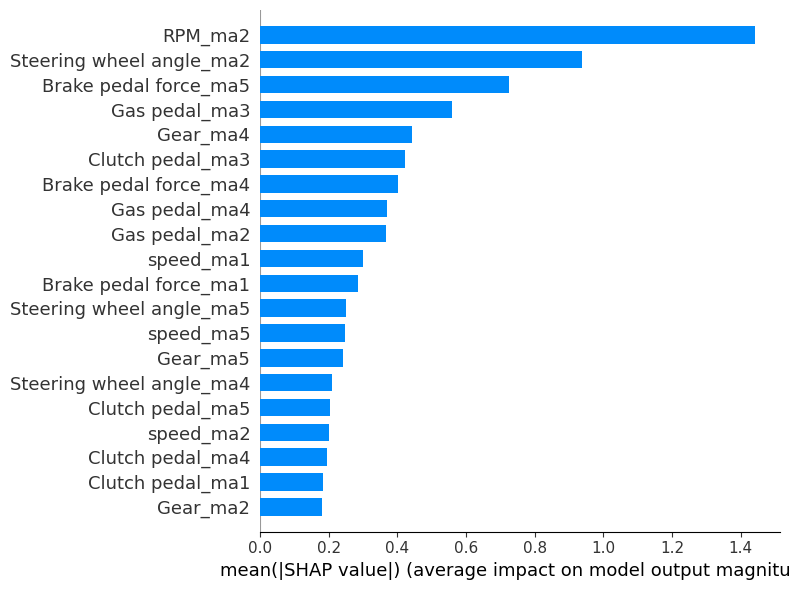

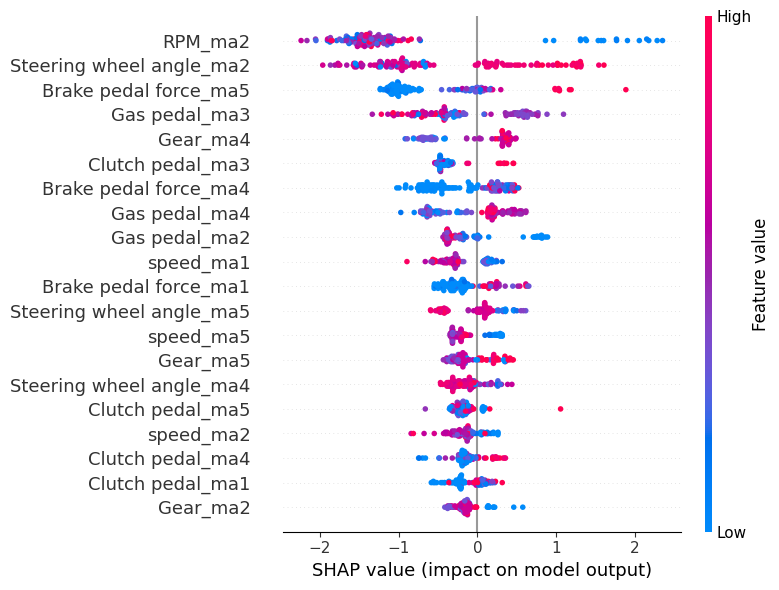

In [42]:
# shap
import shap
# Establecer figsize a (10, 10)
plt.figure(figsize=(10, 10))

explainer = shap.TreeExplainer(model_3step)
shap_values = explainer.shap_values(X_test_flat)

shap.summary_plot(shap_values, X_test_flat, plot_type="bar", plot_size=(8,6))

shap.summary_plot(shap_values, X_test_flat, plot_size=(8,6))

# Supongamos que ya tienes shap_values y X_test_scaled
instance_idx = 0  # Seleccionamos una instancia
# Valor real de la etiqueta para la instancia
real_value = y_test.iloc[instance_idx]  # o y_test[instance_idx] si es un array

### Conclusión

##### Fuga de Datos

Se sospecha fuertemente que hay una fuga de datos por parte de los atributos de latitud y longitud, principalmente del latitud.

Mediante SHAP se ve que laitutd tiene un impacto abrumador en la salida de la predicción.

Se sospecha que esto es algo específico del simulador, en la cual los recorridos parten de la misma posición o que siguen un trayecto espacial muy similar.

Debido a esto, si se mantienen estos datos de localización, el modelo tendría un rendimiento extremadamente alto para situaciones de la simulación mientras que este rendimiento no se trasladaría a uno en la vida real, ya que no estarás siempre en la misma posición recorriendo el mismo trayecto.

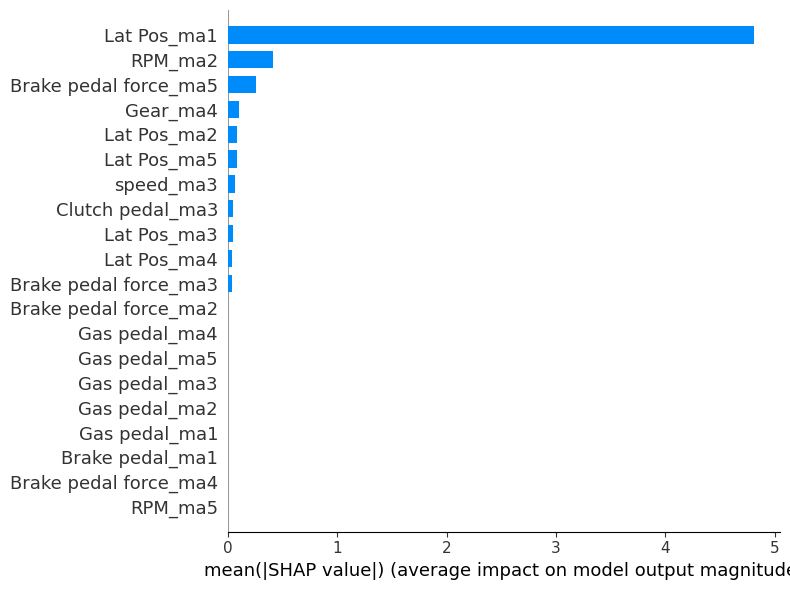
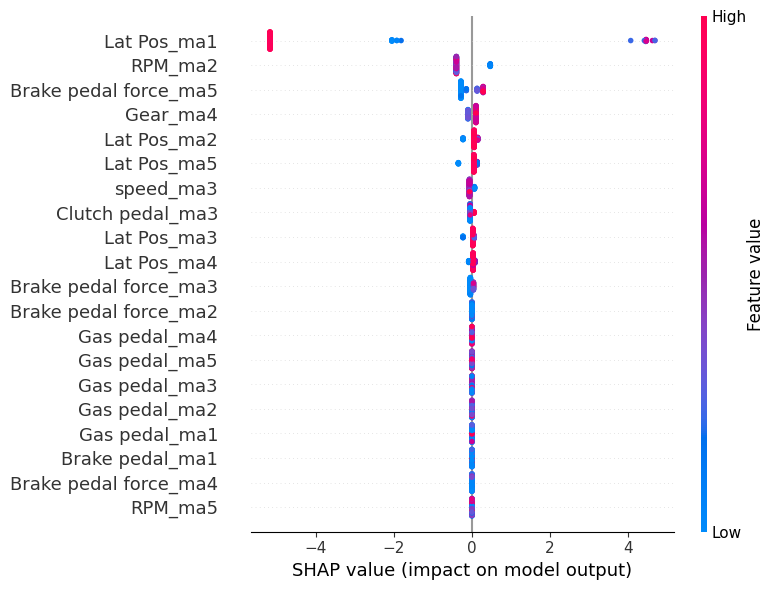


##### Rendimiento del Modelo